In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 비정형 데이터셋에 사용할 수 있는 EDA & Visualization

앞서서 배운 matplotlib / seaborn / plotly (express)를 사용하면 목적에 맞게 시각화를 할 수 있습니다.

일반적으로 비정형 데이터셋 (AI task)에서 시각화는 다음과 같은 시각화를 진행할 수 있습니다.

1. **dataset meta data visualization**
    - target distribution 
        - 훈련 상에서 발생할 수 있는 문제점 예측
        - augmentation 방법론 및 모델 선택 시 도움

2. **dataset listup**
    - only dataset
        - 데이터셋의 일부를 리스트업하여
    - datset-target(bounding box 등)
        - gt, prediction 등을 정답 데이터와 비교하여 문제점 발견 가능

3. **visual analytics**
    - dimension reduction(pca, lda, tsne, umap) + scatter plot (2d, 3d)
        - text의 경우에는 word2vec 등의 과정을 거쳐야함
    - data-data relation  network visualization

3. **train/inference visualization**
    - loss graph
        - wandb / tensorboard 등 다양한 툴로 모델의 훈련과정 확인
    - result

4. **etc**
    - XAI : 
        - [Visual Analytics in Deep Learning: An Interrogative Survey for the Next Frontiers](https://arxiv.org/abs/1801.06889)
        - XAI using torch : https://captum.ai/
        - saliency map (heatmap visualization)
    - node-link diagram (network visualization)
        - http://alexlenail.me/NN-SVG/
        - https://github.com/HarisIqbal88/PlotNeuralNet
        - http://ethereon.github.io/netscope/quickstart.html

이 과정에서 다음과 같은 고민을 병행할 수 있습니다.

- Interaction의 필요성
    - jupyter notebook : 함수형으로 1번에 1개를 만드는 방식
    - web demo : 모든 내용을 한 번에 db에 올려서 사용 (느릴 수 있음)
- 데이터셋의 배치
- 적절한 색과 투명도 사용

## 2. Image Dataset Visualization

이미지 데이터는 시각적으로 보여줄 수 있는 요소가 많으면서도 적습니다.

### 2-1. 이미지 나열

대표적인 이미지 나열에는 Google에서 발표한 Facet이 대표적입니다.

- Facet : https://pair-code.github.io/facets/

간단한 숫자 데이터로 실험을 해보겠습니다.

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
data = digits['data']
target = digits['target']

`ax.imshow`를 사용하여 일반적인 시각화를 진행할 수 있습니다. (또는 `sns.heatmap`, `px.imshow`)

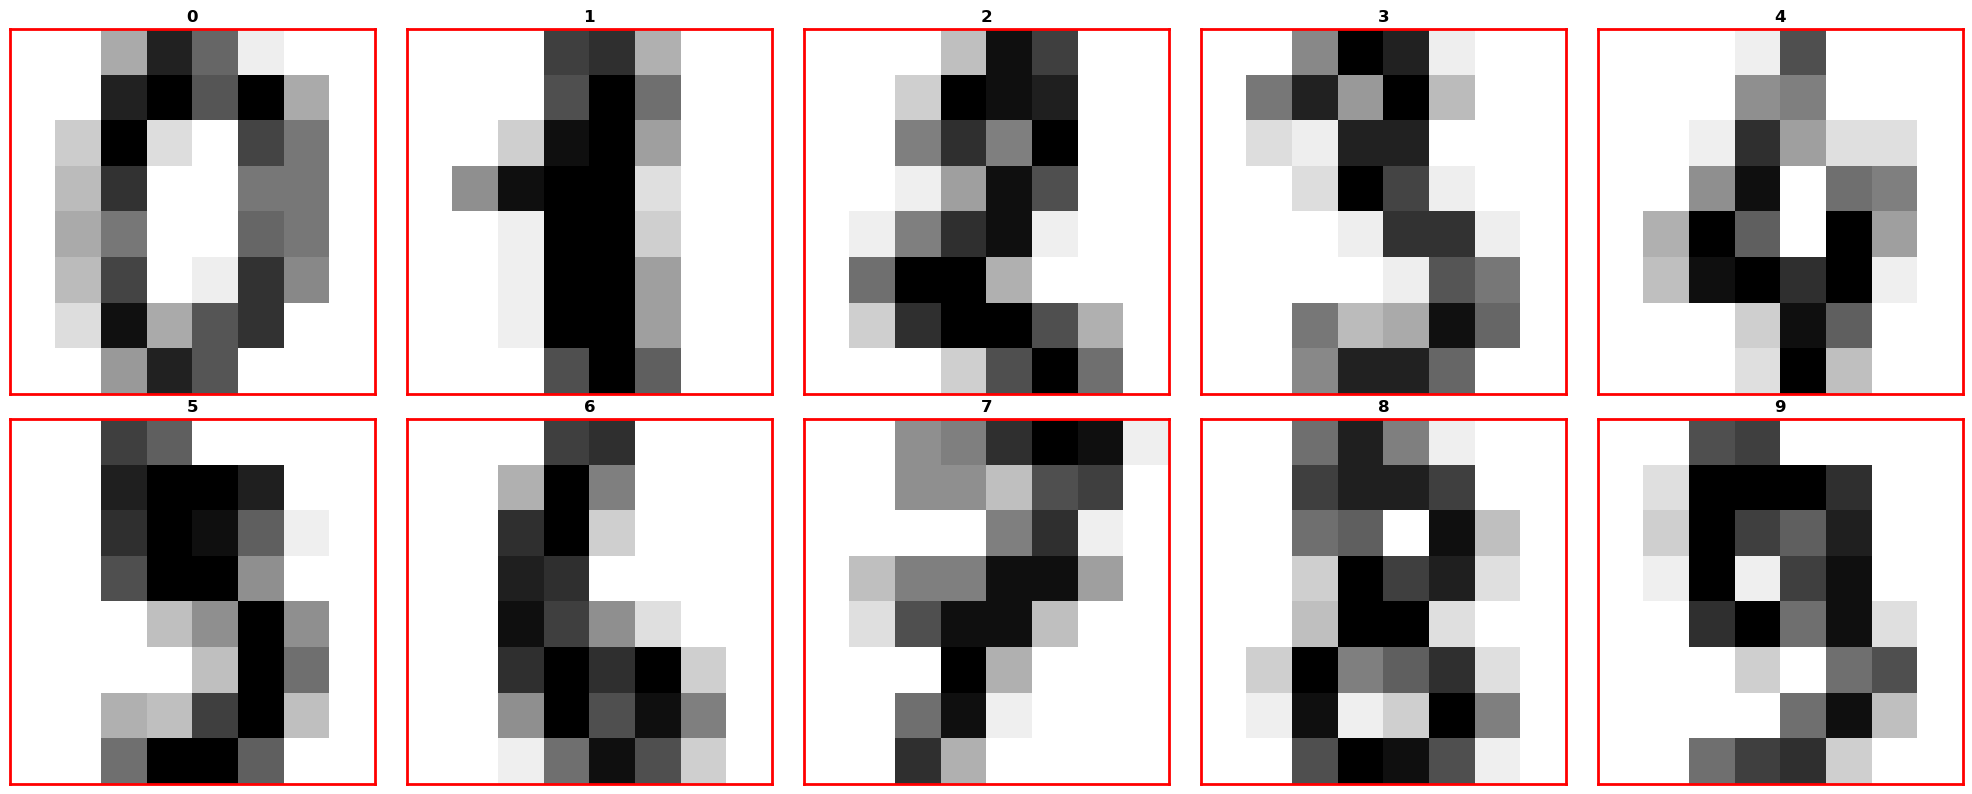

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(data[i].reshape(8, 8), 
                   cmap='gray_r'
                  )

    axes[i].set_title(target[i], fontweight='bold')
    axes[i].spines[['top', 'bottom', 'left', 'right']].set_color('red')
    axes[i].spines[['top', 'bottom', 'left', 'right']].set_linewidth(2)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
#     axes[i].axis('off')

# margin 조정
fig.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0, 
                    hspace=0)

fig.tight_layout()

plt.show()

### 2-2. Patch 사용하기

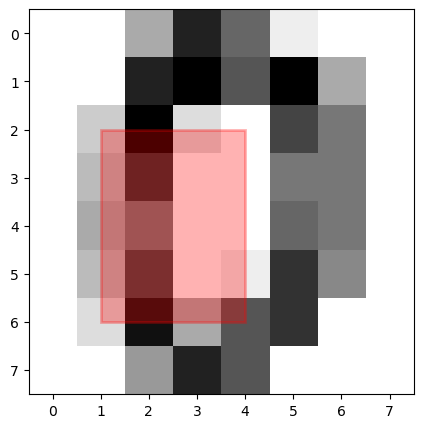

In [4]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(data[0].reshape(8, 8), cmap='gray_r')
# ax.axis('off')

rect = patches.Rectangle((1, 2), 
                         3, 4, 
                         linewidth=2, edgecolor='r', facecolor='red', alpha=0.3)

ax.add_patch(rect)
plt.show()

- Baseline Code by 송원호 마스터님 / 김현우 마스터님

In [9]:
import skimage.io as io
import json
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

dataset_path = './input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: './input/data/train.json'

In [8]:
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

NameError: name 'sorted_df' is not defined

In [ ]:
train_path = dataset_path + '/train.json'
train_dataset = CustomDataLoader(data_dir=train_path, mode='train')

In [ ]:
images, masks, image_infos = train_dataset[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(images)
ax[1].imshow(masks)

plt.show()

기본적으로는 해당 부분을 겹쳐서 보여주는 방법이 있습니다. 이는 투명도로 조정할 수 있습니다.

In [ ]:
images, masks, image_infos = train_dataset[0]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(images)
ax.imshow(masks, alpha=0.5, cmap='gray')


plt.show()

In [ ]:
import plotly.express as px
fig = px.imshow(images)
fig.show()

- mask를 추출하는 부분은 base코드가 있으니 이를 사용하여 interaction추가도 가능

In [ ]:
import plotly.graph_objects as go
from PIL import Image 

def interactive_mask(img_title, img, msk):
    img_width, img_height = 512, 512
    scale_factor = 1.0
    fig = go.Figure()
    image = Image.fromarray((img*255).astype('uint8'))
    fig.add_layout_image(
        dict(
            x=0,
        sizex=img_width * scale_factor,
        y=img_height * scale_factor,
        sizey=img_height * scale_factor,
        xref="x",
        yref="y",
            source=image,
            layer="below",
            sizing="stretch",
        )
    )
    
    fig.add_trace(
        go.Heatmap(z=msk[::-1], colorscale="viridis", opacity=0.5, showscale=False)
    )
 
    
    fig.update_layout(
        updatemenus=[
            go.layout.Updatemenu(
            type="buttons",
            buttons=list([
                dict(label="Sementation",
                     method="update",
                     args=[{"visible": [True]}]),
                dict(label="Raw",
                     method="update",
                     args=[{"visible": [False]}]),
            ]),
        )])
            
    
    


    fig.update_xaxes( visible=False, range=[0, img_width * scale_factor] )
    fig.update_yaxes( visible=False, range=[0, img_height * scale_factor], scaleanchor="x")
    

    fig.show()

In [ ]:
interactive_mask('a', images, masks)

- slider를 사용하여 opacity를 변경할 수 있게 제공
- segmentation별 버튼 생성
- 기본적으로 wandb 등에서 진행할 수 있으니 기존 툴 사용하는 것을 더 추천
    - https://wandb.ai/stacey/deep-drive/reports/Image-Masks-for-Semantic-Segmentation--Vmlldzo4MTUwMw
    - https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection
        - https://github.com/i008/COCO-dataset-explorer

### 2-3. Dimension Reduction + Scatter Plot

TSNE, UMAP 등을 통해 데이터셋의 경향성을 살펴볼 수 있습니다.

일반적으로 cluster가 이뤄지는 지 체크하는 것이 일반적입니다,

In [ ]:
# pip install umap-learn

In [ ]:
from umap import UMAP

data = digits['data']
target = digits['target']

umap = UMAP(random_state=0)
data_dr = umap.fit_transform(data, target)

In [ ]:
from matplotlib.colors import ListedColormap
colors = plt.cm.get_cmap('tab10').colors
colors

In [ ]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(6, 5)
ax = fig.add_subplot(gs[1:-1,1:-1])



sub_axes = [None] * 10
for idx in range(10): 
    sub_axes[idx] = fig.add_subplot(gs[0-idx//5,idx%5])

for idx in range(10):
    ax.scatter(x=data_dr[:,0][target==idx], y=data_dr[:,1][target==idx],
              s=10, alpha=0.1, color=colors[idx]
              )

    for j in range(10):
        sub_axes[j].scatter(x=data_dr[:,0][target==idx], y=data_dr[:,1][target==idx],
                            s=10, alpha = 0.4 if idx==j else 0.008, 
                            color = (colors[j]) if idx==j else 'lightgray',
                            zorder=(idx==j)
                           )
        
    
    inset_ax = sub_axes[idx].inset_axes([0.81, 0.79, 0.2, 0.2])
    inset_ax.axis('off')
    
    
    num_idx = target.tolist().index(idx)
    inset_ax.imshow(data[num_idx].reshape(8, 8), cmap='gray')
    
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    sub_axes[idx].set_xlabel('')
    sub_axes[idx].set_ylabel('')
    sub_axes[idx].spines['right'].set_visible(True)
    sub_axes[idx].spines['top'].set_visible(True)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis('off')

fig.tight_layout()
plt.show()

## 3. Text Dataset Visualization

### 3-1. Console output에 Highlight

- https://stackoverflow.com/questions/287871/how-to-print-colored-text-to-the-terminal
    - https://github.com/ikalnytskyi/termcolor
    - https://github.com/feluxe/sty
    - https://github.com/erikrose/blessings
    - https://github.com/willmcgugan/rich

In [ ]:
# pip install termcolor

In [10]:
from termcolor import colored, cprint

print(colored('hello', 'red'), colored('world', 'green'))
print(colored("hello red world", 'red'))

hello world
hello red world


In [11]:
def word_highligt(txt, word, color=None, highlight=None, attr=None):
    if isinstance(word, str):
        txt = txt.replace(word, colored(word, color, highlight))
    else : 
        if not isinstance(color, list): 
            color = [color] * len(word)
        if not isinstance(highlight, list):
            highlight = [highlight] * len(word)
        for w, c, h in zip(word, color, highlight):
            txt = txt.replace(w, colored(w, c, h))
    return txt

In [12]:
lyrics = """
'Cause I-I-I'm in the stars tonight
So watch me bring the fire and set the night alight
Shoes on, get up in the morn'
Cup of milk, let's rock and roll
King Kong, kick the drum, rolling on like a Rolling Stone
Sing song when I'm walking home
Jump up to the top, LeBron
Ding dong, call me on my phone
Ice tea and a game of ping pong, huh
This is getting heavy
Can you hear the bass boom? I'm ready (woo hoo)
Life is sweet as honey
Yeah, this beat cha-ching like money, huh
Disco overload, I'm into that, I'm good to go
I'm diamond, you know I glow up
Hey, so let's go
'Cause I-I-I'm in the stars tonight
So watch me bring the fire and set the night alight (hey)
Shining through the city with a little funk and soul
So I'ma light it up like dynamite, whoa oh oh
Bring a friend, join the crowd
Whoever wanna come along
Word up, talk the talk
Just move like we off the wall
Day or night, the sky's alight
So we dance to the break of dawn
Ladies and gentlemen, I got the medicine
So you should keep ya eyes on the ball, huh
This is getting heavy
Can you hear the bass boom? I'm ready (woo hoo)
Life is sweet as honey
Yeah, this beat cha-ching like money
Disco overload, I'm into that, I'm good to go
I'm diamond, you know I glow up
Let's go
'Cause I-I-I'm in the stars tonight
So watch me bring the fire and set the night alight (hey)
Shining through the city with a little funk and soul
So I'ma light it up like dynamite, whoa oh oh
Dy-na-na-na, na-na, na-na-na, na-na-na, life is dynamite
Dy-na-na-na, na-na, na-na-na, na-na-na, life is dynamite
Shining through the city with a little funk and soul
So I'ma light it up like dynamite, whoa oh oh
Dy-na-na-na, na-na, na-na, ayy
Dy-na-na-na, na-na, na-na, ayy
Dy-na-na-na, na-na, na-na, ayy
Light it up like dynamite
Dy-na-na-na, na-na, na-na, ayy
Dy-na-na-na, na-na, na-na, ayy
Dy-na-na-na, na-na, na-na, ayy
Light it up like dynamite
'Cause I-I-I'm in the stars tonight
So watch me bring the fire and set the night alight
Shining through the city with a little funk and soul
So I'ma light it up like dynamite (this is ah)
'Cause I-I-I'm in the stars tonight
So watch me bring the fire and set the night alight (alight, oh)
Shining through the city with a little funk and soul
So I'ma light it up like dynamite, whoa (light it up like dynamite)
Dy-na-na-na, na-na, na-na-na, na-na-na, life is dynamite
Dy-na-na-na, na-na, na-na-na, na-na-na, life is dynamite
Shining through the city with a little funk and soul
So I'ma light it up like dynamite, whoa oh oh
"""

In [13]:
print(word_highligt(lyrics, 'me', None, 'on_red'))


'Cause I-I-I'm in the stars tonight
So watch me bring the fire and set the night alight
Shoes on, get up in the morn'
Cup of milk, let's rock and roll
King Kong, kick the drum, rolling on like a Rolling Stone
Sing song when I'm walking home
Jump up to the top, LeBron
Ding dong, call me on my phone
Ice tea and a game of ping pong, huh
This is getting heavy
Can you hear the bass boom? I'm ready (woo hoo)
Life is sweet as honey
Yeah, this beat cha-ching like money, huh
Disco overload, I'm into that, I'm good to go
I'm diamond, you know I glow up
Hey, so let's go
'Cause I-I-I'm in the stars tonight
So watch me bring the fire and set the night alight (hey)
Shining through the city with a little funk and soul
So I'ma light it up like dynamite, whoa oh oh
Bring a friend, join the crowd
Whoever wanna come along
Word up, talk the talk
Just move like we off the wall
Day or night, the sky's alight
So we dance to the break of dawn
Ladies and gentlemen, I got the medicine
So you should keep ya eye

In [14]:
print(word_highligt(lyrics,  ['to', 'I'], [None, 'cyan'], ['on_red', None]))


'Cause I-I-I'm in the stars tonight
So watch me bring the fire and set the night alight
Shoes on, get up in the morn'
Cup of milk, let's rock and roll
King Kong, kick the drum, rolling on like a Rolling Stone
Sing song when I'm walking home
Jump up to the top, LeBron
Ding dong, call me on my phone
Ice tea and a game of ping pong, huh
This is getting heavy
Can you hear the bass boom? I'm ready (woo hoo)
Life is sweet as honey
Yeah, this beat cha-ching like money, huh
Disco overload, I'm into that, I'm good to go
I'm diamond, you know I glow up
Hey, so let's go
'Cause I-I-I'm in the stars tonight
So watch me bring the fire and set the night alight (hey)
Shining through the city with a little funk and soul
So I'ma light it up like dynamite, whoa oh oh
Bring a friend, join the crowd
Whoever wanna come along
Word up, talk the talk
Just move like we off the wall
Day or night, the sky's alight
So we dance to the break of dawn
Ladies and gentlemen, I got the medicine
So you should keep ya eye

### 3-2. IPython의 HTML의 활용

In [15]:
from IPython.core.display import HTML
HTML("<span style='color:red'>hello</span> word")

In [16]:
def word_highligt_html(txt, word, color='black', highlight=None, attr=None):
    if isinstance(word, str):
        txt = txt.replace(word, f'<span style="color: {color}; background-color:{highlight}">{word}</span>')
    else : 
        if not isinstance(color, list): 
            color = [color] * len(word)
        if not isinstance(highlight, list):
            highlight = [highlight] * len(word)
        for w, c, h in zip(word, color, highlight):

            txt = txt.replace(w, f'<span style="color: {c}; background-color:{h}">{w}</span>')
    return txt

In [17]:
HTML(word_highligt_html(lyrics, ['and', 'Yeah'], ['red', 'white'],  [None, '#B19CD9']))

이런 범용 툴 및 라이브러리 소스들이 있으니 살펴보면 좋습니다.

- LIT : https://github.com/PAIR-code/lit
    - interactive model-understanding tool for NLP models
- Ecco : https://www.eccox.io/
    - Ecco is a python library that creates interactive visualizations allowing you to explore what your NLP Language Model is thinking.
- https://github.com/jessevig/bertviz
- https://github.com/jbesomi/texthero
- https://github.com/bmabey/pyLDAvis
- https://github.com/JasonKessler/scattertext
- https://github.com/ryanjgallagher/shifterator

## Further Reading 

딥러닝/머신러닝을 공부하는 분들에게 마지막 전달하는 AI + Visualization 자료



- Distill.pub : https://distill.pub/
- Poloclub : https://poloclub.github.io/
- Google Pair : https://pair.withgoogle.com/
- Open AI Blog : https://openai.com/blog/

---

그 외 visualization 아이디어를 얻을 수 있는 소스

- Observable : https://observablehq.com/
- https://textvis.lnu.se/
- https://visimages.github.io/visimages-explorer/

좋은 프로젝트 / 좋은 연구를 응원합니다!!

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

